# Exploring the Outcomes for Shelter Animals in Sonoma County

## Introduction

Sonoma County, California maintains and makes available to the public a dataset of animals that come in to and out of its shelter system. This data includes information on each animal's species, sex, spay/neuter status, estimated date of birth, health, size, color, breed, what ultimately happens to them, and many more. We've analyzed the contents of this data to see not only what the outcomes for these animals are, but how long they tend to spend in the shelter system, and what factors ultimately influence their outcomes the most.

We have three main questions we aim to answer.

1.   Do black dogs and cats get adopted less often than other colors?
2.   What factors influence an animal's outcome type the most? In particular, what influences adoption and euthanasia rates?
3.   What factors influence the length of an animal's stay at the shelter the most?



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook', style='whitegrid')

## Initial Data Exploration

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/grbruns/cst383/master/sonoma-shelter-12-oct-2023.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26350 entries, 0 to 26349
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  19420 non-null  object 
 1   Type                  26350 non-null  object 
 2   Breed                 26350 non-null  object 
 3   Color                 26350 non-null  object 
 4   Sex                   26350 non-null  object 
 5   Size                  26315 non-null  object 
 6   Date Of Birth         19853 non-null  object 
 7   Impound Number        26350 non-null  object 
 8   Kennel Number         26297 non-null  object 
 9   Animal ID             26350 non-null  object 
 10  Intake Date           26350 non-null  object 
 11  Outcome Date          26089 non-null  object 
 12  Days in Shelter       26350 non-null  int64  
 13  Intake Type           26350 non-null  object 
 14  Intake Subtype        26350 non-null  object 
 15  Outcome Type       

## Data preprocessing

In [ ]:
# Convert dates to pandas date format
df['Date Of Birth'] = pd.to_datetime(df['Date Of Birth'])
df['Intake Date'] = pd.to_datetime(df['Intake Date'])
df['Outcome Date'] = pd.to_datetime(df['Outcome Date'])
# Convert certain columns to categorical values, and standartize their colors/order when plotting
outcome_type_order = ['Adoption','Euthanize','Transfer','Return to Owner','Other']
intake_type_order = ['Stray','Owner Surrender','Confiscate','Other']
df['Intake Type'] = pd.Categorical(df['Intake Type'])
df['Outcome Type'] = pd.Categorical(df['Outcome Type'])
# Truncate outcome and intake types other than the 3 or 4 most common under 'Other'
df['Outcome Type'] = df['Outcome Type'].apply(lambda x: x if x in ['ADOPTION','EUTHANIZE','TRANSFER','RETURN TO OWNER'] else 'OTHER')
df['Intake Type'] = df['Intake Type'].apply(lambda x: x if x in ['STRAY','OWNER SURRENDER','CONFISCATE'] else 'OTHER')
# Convert intake and outcome reasons to title case ("Adoption" instead of "ADOPTION") so they look a little nicer (and fit in legends more compactly)
df['Intake Type'] = df['Intake Type'].str.title()
df['Outcome Type'] = df['Outcome Type'].str.title()
df['Outcome Type'] = df['Outcome Type'].replace({'Return To Owner': 'Return to Owner'})
# Create an age column
df['Age']= (df['Outcome Date']-df['Date Of Birth']).dt.days/365
# This allows us to bin animals into different age groups.
age_bins = [0, 1, 3, 5, float('inf')]
age_labels = ['0-1', '1-3', '3-5', '5+']
df['Age Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)
# These slices give easy access to dogs and cats from the dataframe
df_dogs=df[df['Type']=="DOG"]
df_cats=df[df['Type']=="CAT"]
# Many of our plots will involve animal color, so we need to isolate the top 10 most common dog and cat colors
top10DogColors = df_dogs['Color'].value_counts()[0:10]
top10CatColors = df_cats['Color'].value_counts()[0:10]
# We will need popular dog breeds as well
top10DogBreeds = df_dogs['Breed'].value_counts()[0:10]

## Data exploration and visualization

About 14000 of the rows in the data represent dogs, cats make a little over 9000, and about 2000 are other animals. Since dogs and cats are such different animals, it may be helpful to keep them separate for most visualizations. For example, dogs and cats come in different colors, so an analysis of the colors of animals that get adopted may need to be kept separate.

### "Black Dog Syndrome"

**Motivate**:

On the subject of color, one popular conventional thought, sometimes called "Black Dog Syndrome", holds that black dogs and cats are less likely to be adopted. The following is a breakdown of the average number of days spent at shelters for the top 10 most common dog and cat colors, respectively.

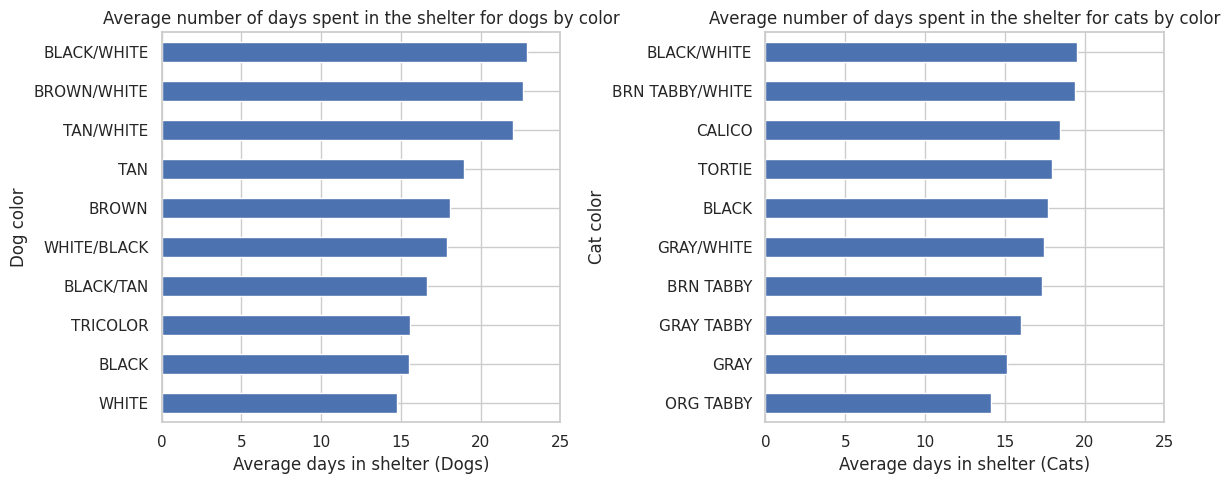

In [ ]:
# We will use df_filtered_dogs and df_filtered_cats for many of our plots and use it to filter whatever values we need
df_filtered_dogs = df_dogs[df_dogs['Color'].isin(top10DogColors.index)]
df_filtered_cats = df_cats[df_cats['Color'].isin(top10CatColors.index)]

fig,ax = plt.subplots(1, 2, figsize=(12,5))
df_filtered_dogs.groupby('Color')['Days in Shelter'].mean().sort_values().plot.barh(ax=ax[0])
ax[0].set_title('Average number of days spent in the shelter for dogs by color')
ax[0].set_xlabel('Average days in shelter (Dogs)')
ax[0].set_ylabel('Dog color')
ax[0].set_xlim(0,25)
df_filtered_cats.groupby('Color')['Days in Shelter'].mean().sort_values().plot.barh(ax=ax[1])
ax[1].set_title('Average number of days spent in the shelter for cats by color')
ax[1].set_xlabel('Average days in shelter (Cats)')
ax[1].set_ylabel('Cat color')
ax[1].set_xlim(0,25)
fig.tight_layout();

**Interpret**:

 It looks like for both dogs and cats, black tends to have some of the shortest time spent in shelters. Is the conventional wisdom that black animals are less likely to be adopted not true? Unfortunately, a short stay at a shelter does not always mean a happy ending for an animal.

**Motivate**:

Are black dogs and cats having shorter stays because they are being adopted, or do they have different outcomes than other colors?

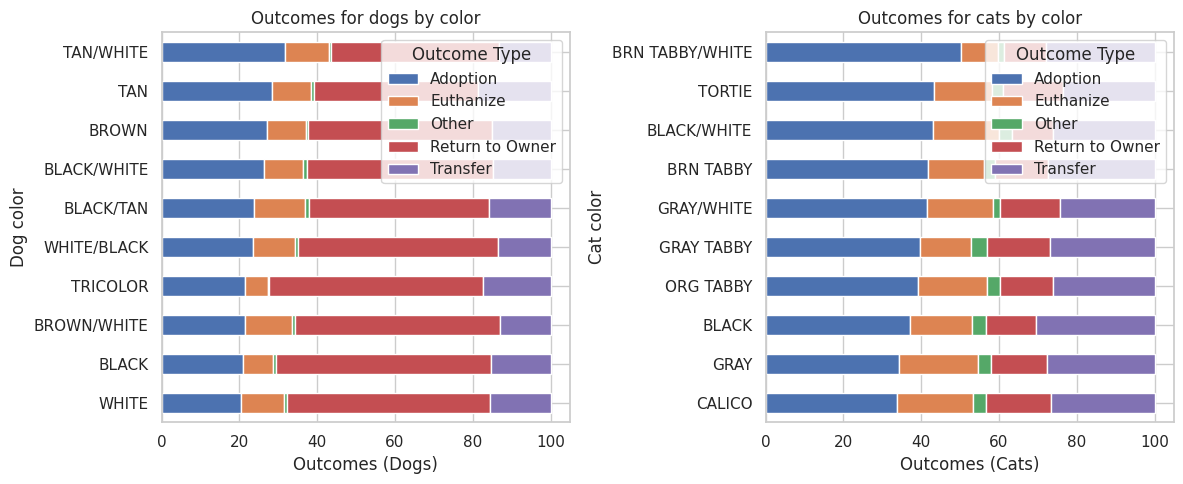

In [ ]:
dogCrosstab = pd.crosstab(df_filtered_dogs['Color'], df_filtered_dogs['Outcome Type'],normalize='index').sort_values(by='Adoption')*100
catCrosstab = pd.crosstab(df_filtered_cats['Color'], df_filtered_cats['Outcome Type'],normalize='index').sort_values(by='Adoption')*100

fig,ax = plt.subplots(1, 2, figsize=(12,5))
dogCrosstab.plot.barh(stacked=True,ax=ax[0])
ax[0].set_title('Outcomes for dogs by color')
ax[0].set_xlabel('Outcomes (Dogs)')
ax[0].set_ylabel('Dog color')
catCrosstab.plot.barh(stacked=True,ax=ax[1])
ax[1].set_title('Outcomes for cats by color')
ax[1].set_xlabel('Outcomes (Cats)')
ax[1].set_ylabel('Cat color')
fig.tight_layout()
plt.legend(loc='upper right', title='Outcome Type');

**Interpret**:

It looks like black animals are some of the least likely to be adopted, but not by a particularly alarming margin, and their euthanasia rates do not seem unusually high. In fact, it seems black dogs are some of the least likely to be euthanized. But do we know for a fact that Black Dog syndrome is a myth?

### Intake and Outcome relationships

**Motivate**:
In order to better understand the outcomes for animals, we need to look at the reasons they come into a shelter. An animal that is confiscated from its owner may have different possibilities available to it from a stray, or a surrendered animal.

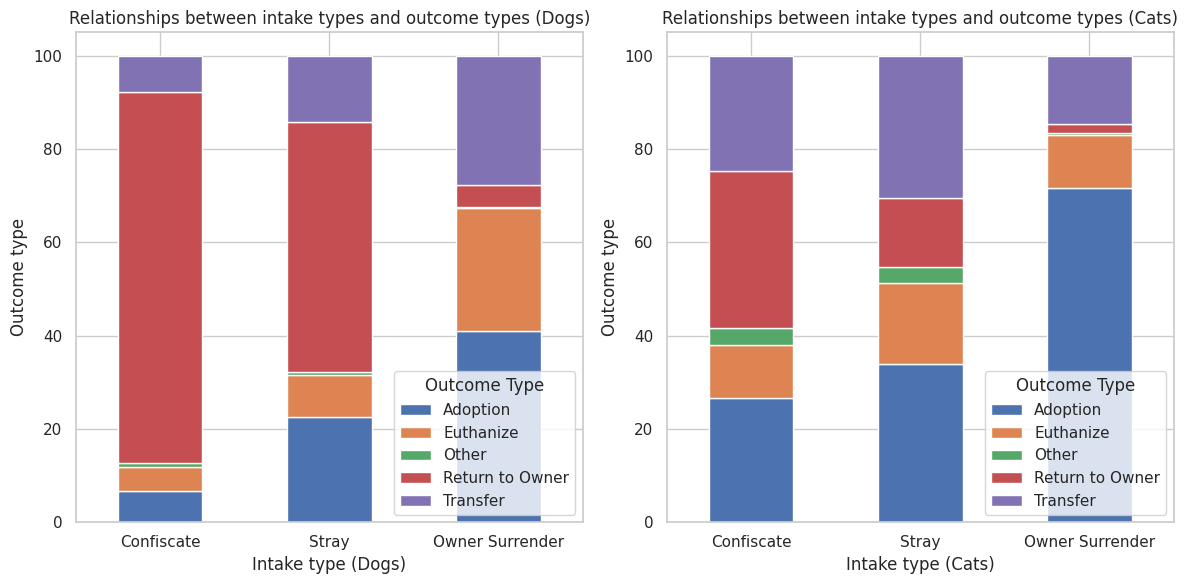

In [ ]:
# We're ignoring animals with uncommon or "other" intake types, as confiscations, surrenders, and strays represent a large majority of the intakes
df_filtered_dogs=df_dogs[df_dogs['Intake Type']!="Other"]
df_filtered_cats=df_cats[df_cats['Intake Type']!="Other"]
dogCrosstab = pd.crosstab(df_filtered_dogs['Intake Type'], df_filtered_dogs['Outcome Type'],normalize='index').sort_values(by='Adoption')*100
catCrosstab = pd.crosstab(df_filtered_cats['Intake Type'], df_filtered_cats['Outcome Type'],normalize='index').sort_values(by='Adoption')*100
fig,ax = plt.subplots(1, 2, figsize=(12,6))
dogCrosstab.plot.bar(stacked=True,ax=ax[0],rot=0)
ax[0].set_title('Relationships between intake types and outcome types (Dogs)')
ax[0].set_ylabel('Outcome type')
ax[0].set_xlabel('Intake type (Dogs)')
ax[0].legend(loc='lower right', title='Outcome Type')
catCrosstab.plot.bar(stacked=True,ax=ax[1],rot=0)
ax[1].set_title('Relationships between intake types and outcome types (Cats)')
ax[1].set_ylabel('Outcome type')
ax[1].set_xlabel('Intake type (Cats)')
ax[1].legend(loc='lower right', title='Outcome Type')
fig.tight_layout()
plt.show();

**Interpret**:

For simplicity, only the three most common intake reasons (Confiscation, Stray, and Surrenders) are shown here, but there are several other intake types.

The most surprising piece of information to be seen here is that dogs who are confiscated from the owner are nearly always returned to the owner, almost 80% of the time. Animals that are surrendered by their owners are most often adopted, but euthanasia is still a distinct possibility for surrendered dogs. About 70% of surrendered cats are eventually adopted.

**Motivate**:

Sonoma County also records data on the health of animals at the time they enter and leave the shelter. What is the relationship between an animal's intake condition and it's outcome type?

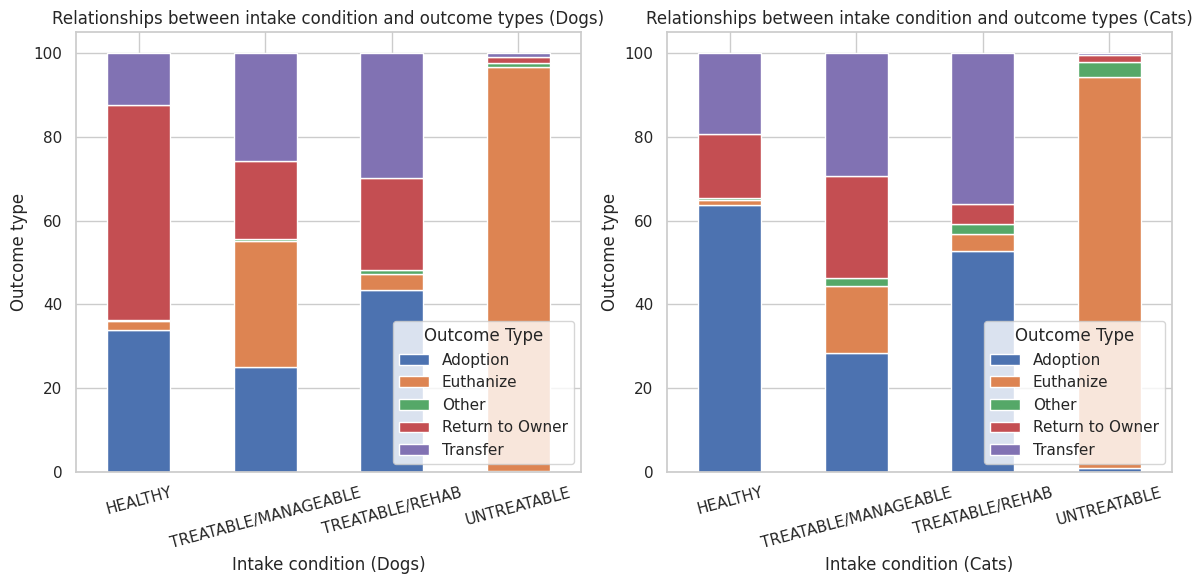

In [ ]:
# We want to ignore animals with an unknown intake condition
df_filtered_dogs=df_dogs[df_dogs['Intake Condition']!="UNKNOWN"]
df_filtered_cats=df_cats[df_cats['Intake Condition']!="UNKNOWN"]
dogCrosstab = pd.crosstab(df_filtered_dogs['Intake Condition'], df_filtered_dogs['Outcome Type'],normalize='index')*100
catCrosstab = pd.crosstab(df_filtered_cats['Intake Condition'], df_filtered_cats['Outcome Type'],normalize='index')*100
fig,ax = plt.subplots(1, 2, figsize=(12,6))
dogCrosstab.plot.bar(stacked=True,ax=ax[0],rot=15)
ax[0].set_title('Relationships between intake condition and outcome types (Dogs)')
ax[0].set_ylabel('Outcome type')
ax[0].set_xlabel('Intake condition (Dogs)')
ax[0].legend(loc='lower right', title='Outcome Type')
catCrosstab.plot.bar(stacked=True,ax=ax[1],rot=15)
ax[1].set_title('Relationships between intake condition and outcome types (Cats)')
ax[1].set_ylabel('Outcome type')
ax[1].set_xlabel('Intake condition (Cats)')
ax[1].legend(loc='lower right', title='Outcome Type')
fig.tight_layout()
plt.show();

**Interpret**:

Unsurprisingly, nearly all animals labeled as "untreatable" ended up euthanized. Animals that enter the shelter labeled as "Treatable/Rehab" actually have the highest rates of adoption when it comes to dogs, even higher than the adoption rate of healthy animals. It may be the case that healthy animals are more often returned to their owners, so many healthy animals may have simply been lost pets.

**Motivate**:

It's clear that some animals may never have any likelihood of being adopted, because they were unhealthy, already had an owner, or have some issue that is not tracked in this data. With this in mind, we can revisit the earlier question of what happens to black animals if we only factor in animals that are likely adoptable. We can filter out animals that are returned to their owners, as well as only look at animals that are healthy at their release.

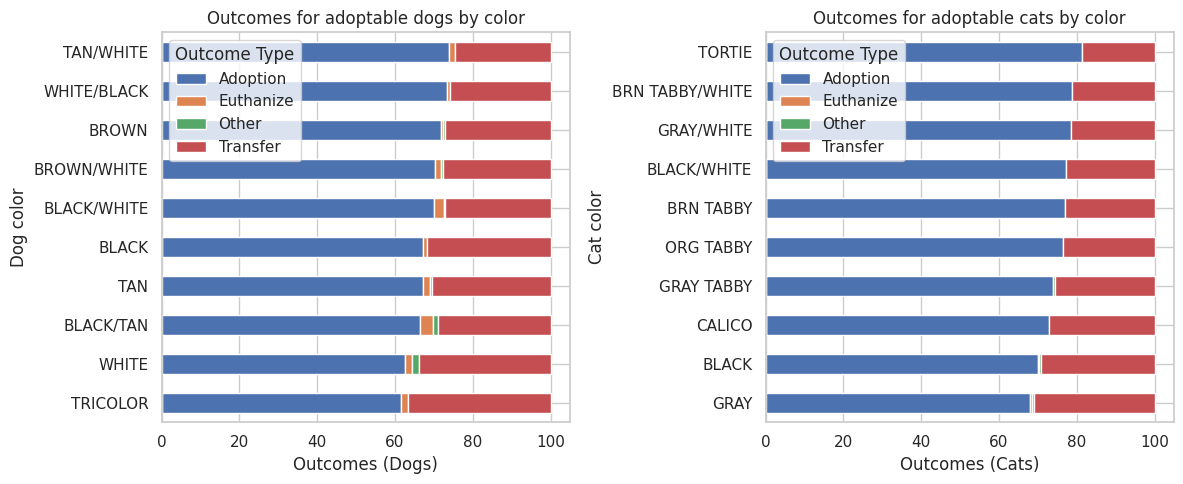

In [ ]:
# We're going to filter only healthy animals that aren't known to have owners, to create lists of 'adoptable' dogs and cats
df_adoptable_dogs = df_dogs[((df_dogs['Outcome Condition']=='HEALTHY')&(df_dogs['Outcome Type']!='Return to Owner'))]
df_adoptable_cats = df_cats[((df_cats['Outcome Condition']=='HEALTHY')&(df_cats['Outcome Type']!='Return to Owner'))]
df_filtered_dogs = df_adoptable_dogs[(df_adoptable_dogs['Color'].isin(top10DogColors.index))]
df_filtered_cats = df_adoptable_cats[(df_adoptable_cats['Color'].isin(top10CatColors.index))]
dogCrosstab = pd.crosstab(df_filtered_dogs['Color'], df_filtered_dogs['Outcome Type'],normalize='index').sort_values(by='Adoption')*100
catCrosstab = pd.crosstab(df_filtered_cats['Color'], df_filtered_cats['Outcome Type'],normalize='index').sort_values(by='Adoption')*100

fig,ax = plt.subplots(1, 2, figsize=(12,5))
dogCrosstab.plot.barh(stacked=True,ax=ax[0])
ax[0].set_title('Outcomes for adoptable dogs by color')
ax[0].set_xlabel('Outcomes (Dogs)')
ax[0].set_ylabel('Dog color')
ax[0].legend(loc='upper left', title='Outcome Type')
catCrosstab.plot.barh(stacked=True,ax=ax[1])
ax[1].set_title('Outcomes for adoptable cats by color')
ax[1].set_xlabel('Outcomes (Cats)')
ax[1].set_ylabel('Cat color')
ax[1].legend(loc='upper left', title='Outcome Type')
fig.tight_layout();

**Interpret**:

Simply by removing animals that are returned to their owners and aren't healthy on their outcome date, we see almost no healthy animals are ever euthanized. Furthermore, we can see that black dogs are in the middle of the pack in terms of adoption rates. Black cats are only marginally less likely to be adopted than tortoiseshell coat cats.

**Motivate**:

Finally, we need to look at just animals who do get adopted. How long do they spend in the shelter before getting adopted?

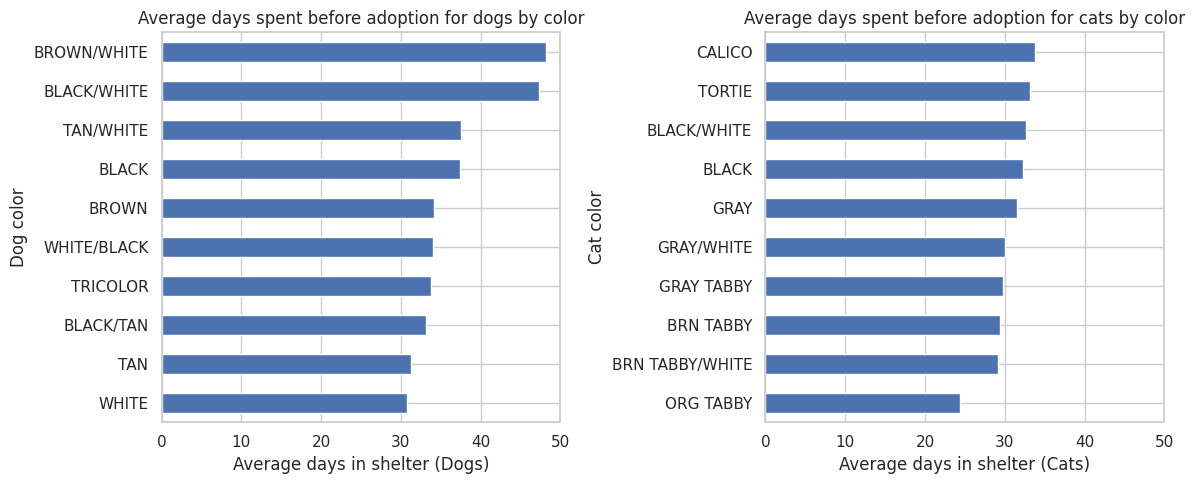

In [ ]:
df_filtered_dogs = df_dogs[(df_dogs['Color'].isin(top10DogColors.index))&(df_dogs['Outcome Type']=='Adoption')]
df_filtered_cats = df_cats[(df_cats['Color'].isin(top10CatColors.index))&(df_cats['Outcome Type']=='Adoption')]

fig,ax = plt.subplots(1, 2, figsize=(12,5))
df_filtered_dogs.groupby('Color')['Days in Shelter'].mean().sort_values().plot.barh(ax=ax[0])
ax[0].set_title('Average days spent before adoption for dogs by color')
ax[0].set_xlabel('Average days in shelter (Dogs)')
ax[0].set_ylabel('Dog color')
ax[0].set_xlim(0,50)
df_filtered_cats.groupby('Color')['Days in Shelter'].mean().sort_values().plot.barh(ax=ax[1])
ax[1].set_title('Average days spent before adoption for cats by color')
ax[1].set_xlabel('Average days in shelter (Cats)')
ax[1].set_ylabel('Cat color')
ax[1].set_xlim(0,50)
fig.tight_layout();

**Interpret**:

Multicolored dogs typically take a little longer to adopt out, while white ones go quickly. For cats, tabbies get adopted very quickly, and calicoes tend to take a little longer. Neither animal seems to be doomed to an eternity at the shelter for being black, however. It seems that "Black Animal Syndrome" is a myth, or at least a major exaggeration. Cats in general seem to be adopted much more quickly than dogs.

### Outcomes for Various Dog Breeds

**Motivate**:

We also need to explore what outcomes look like for animals based on their breed. Cat breeds are almost always simply domestic shorthair, so for these plots we will only look at dog breeds.

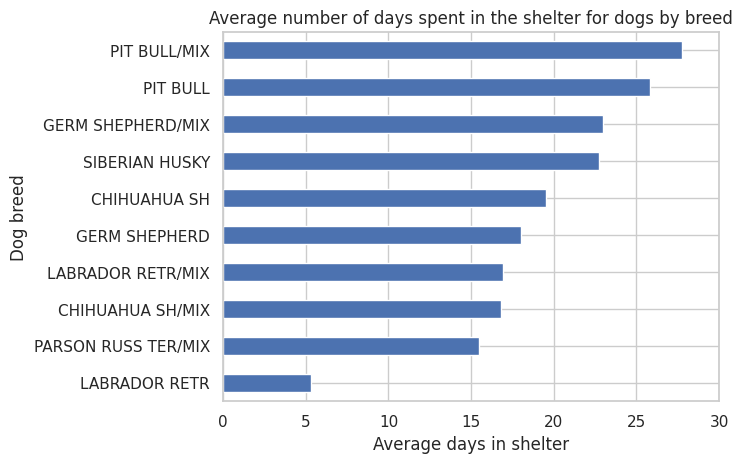

In [ ]:
df_filtered_dogs = df[(df['Type']=='DOG') & (df['Breed'].isin(top10DogBreeds.index))]

df_filtered_dogs.groupby('Breed')['Days in Shelter'].mean().sort_values().plot.barh()
plt.title('Average number of days spent in the shelter for dogs by breed')
plt.xlabel('Average days in shelter')
plt.ylabel('Dog breed')
plt.xlim(0,30)

plt.show()

**Interpret**:

As we can see, pit bulls and pit bull mixes tend to spend relatively long times at the shelter, whereas labradors tend to enjoy shorter stays. Even with 510 total Labrador Retrievers in the data, they somehow average only 5 days spent in the shelter, as opposed to pit bulls who average over 25 days.

**Motivate**:

Are there any outlier values in the data that are skewing the mean stay length for each breed? These box plots illustrate the median stay length for each breed, as well as show outliers.

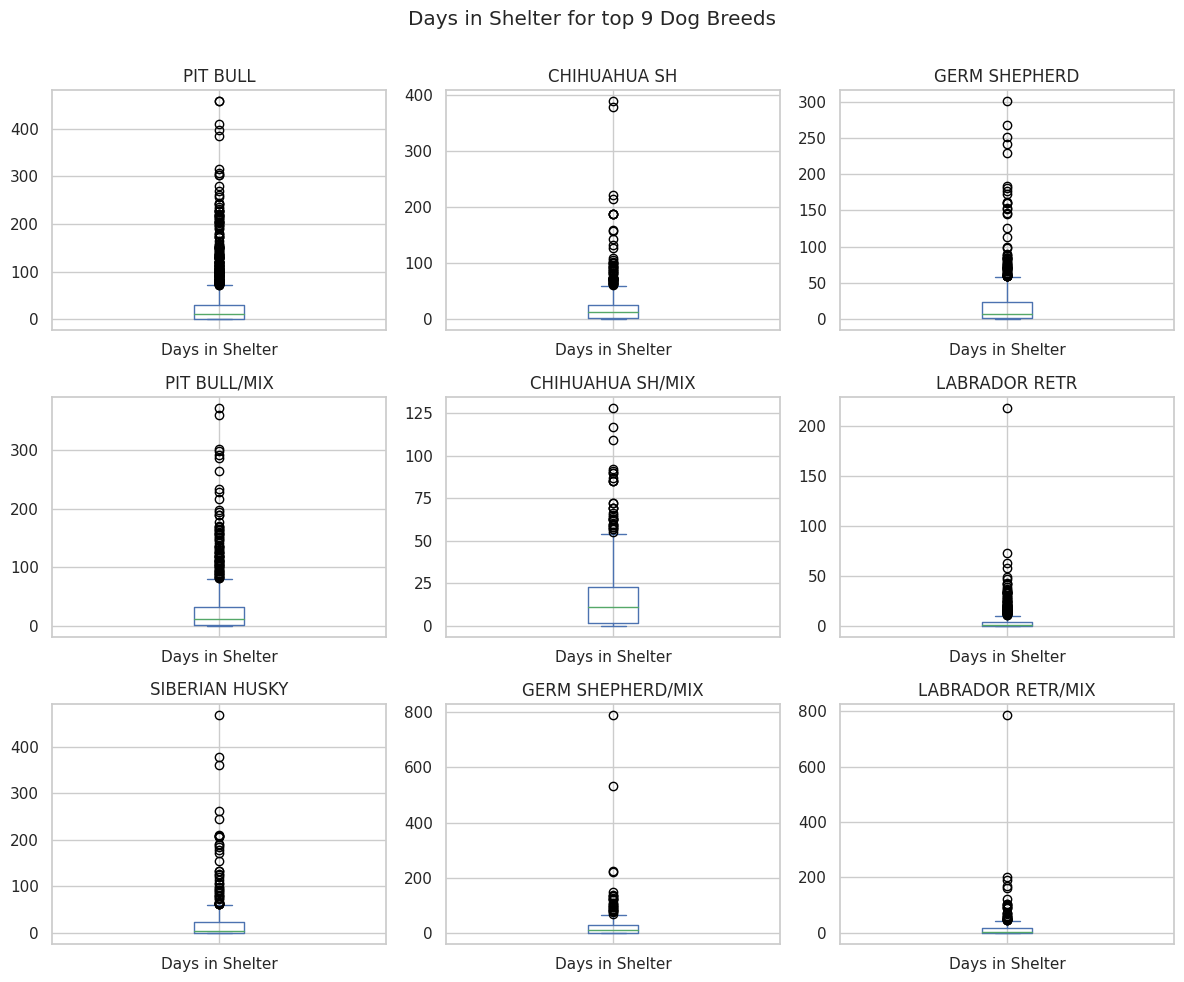

In [ ]:
df_filtered_dogs = df[(df['Type']=='DOG') & (df['Breed'].isin(top10DogBreeds.index))]
top_10_breeds = df_filtered_dogs['Breed'].value_counts().head(9).index.tolist()
plt.figure(figsize=(12, 10))
plt.suptitle('Days in Shelter for top 9 Dog Breeds')
i=0
for breed in top_10_breeds:
  plt.subplot(3, 3, i + 1)
  df_filtered_dogs[df_filtered_dogs['Breed'] == breed]['Days in Shelter'].plot.box(title=breed)
  i=i+1
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

**Interpret**:

In these box plots, the blue boxes represent where the majority of the dogs lie in terms of stay length for each breed, while black cirlces repesent outliers with unusally large stay lengths. Clearly, every breed of dog has at least a few outliers who stay much longer than average, including a couple of dogs who stayed in the shelter almost 800 days. The previous plot showed that pit bull mixes had the longest stays, and this plot partially shows why: pit bulls and pit mixes have more outliers than any other breed.


**Motivate:**

What are outcomes like for the various dog breeds? Are some dog breeds getting adopted or euthanized more than others?

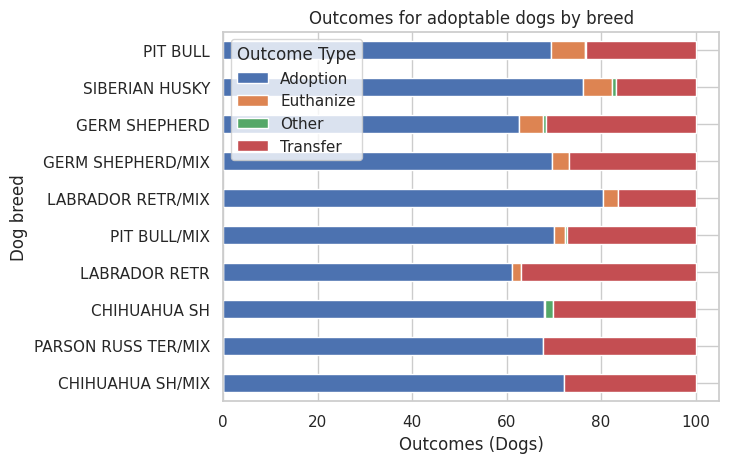

In [ ]:
df_filtered_dogs = df_adoptable_dogs[df_adoptable_dogs['Breed'].isin(top10DogBreeds.index)]
dogCrosstab = pd.crosstab(df_filtered_dogs['Breed'], df_filtered_dogs['Outcome Type'],normalize='index').sort_values(by='Euthanize')*100

dogCrosstab.plot.barh(stacked=True,title='Outcomes for adoptable dogs by breed')
plt.xlabel('Outcomes (Dogs)')
plt.ylabel('Dog breed')
plt.legend(loc='upper left', title='Outcome Type');

**Interpret**:

The above graphic is organized by euthanasia rates, highest to lowest. Pit bulls have the highest rate of euthanasia, even among dogs that meet our criteria for adoptability. Chihuahuas on the other hand are seemingly never euthanized.

Labrador retriver mixes seem to have the highest adoption rates, and labrador retrievers have the lowest.

### Further analysis of animal outcomes

**Motivate**:

Sonoma county also keeps a record of the estimated age of animals in it's shelters. Although this information is likely not as reliable as some other columns, it may still reveal some interesting findings. What is the typical age of animals for each of the most common outcomes?

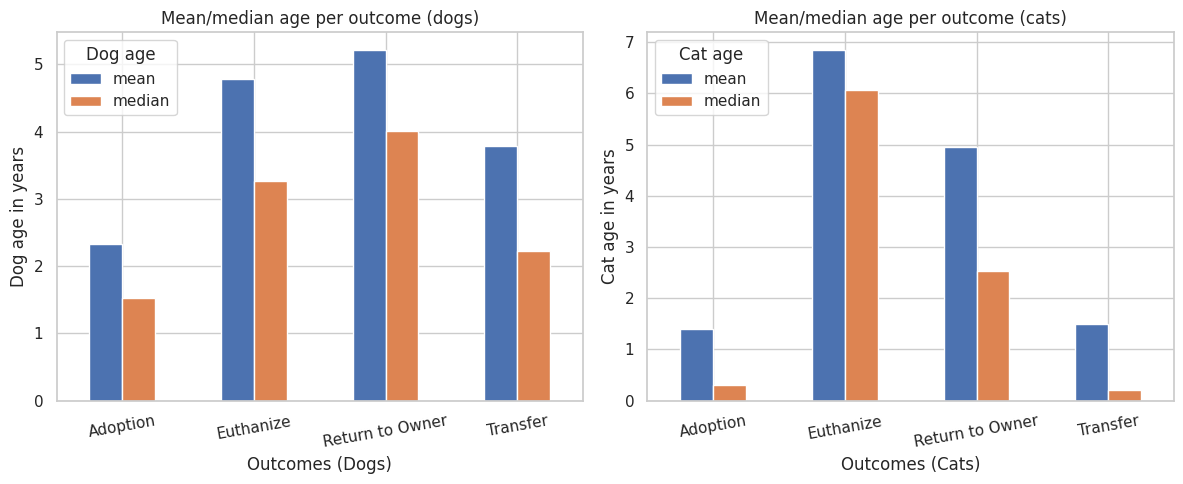

In [ ]:
df_filtered_dogs=df_dogs[df_dogs['Outcome Type']!="Other"]
df_filtered_cats=df_cats[df_cats['Outcome Type']!="Other"]
fig,ax = plt.subplots(1, 2, figsize=(12,5))
df_filtered_dogs.groupby('Outcome Type')['Age'].agg(['mean', 'median']).plot.bar(ax=ax[0],rot=10)
ax[0].set_title('Mean/median age per outcome (dogs)')
ax[0].set_xlabel('Outcomes (Dogs)')
ax[0].set_ylabel('Dog age in years')
ax[0].legend(loc='upper left', title='Dog age')
df_filtered_cats.groupby('Outcome Type')['Age'].agg(['mean', 'median']).plot.bar(ax=ax[1],rot=10)
ax[1].set_title('Mean/median age per outcome (cats)')
ax[1].set_xlabel('Outcomes (Cats)')
ax[1].set_ylabel('Cat age in years')
ax[1].legend(loc='upper left', title='Cat age')
fig.tight_layout();

**Interpret**:

The most striking statistic is the difference in age between the typical adopted cat and the ages of cats that are euthanized. The median age of a cat that is euthanized is 6 years old, as opposed to around 3 months for cats being adopted. The mean adoption age is over a year old, however, showing that it's still very possible for an adult cat to be adopted. Dogs, however, typically are over a year old when being adopted. There does not seem to be nearly as many puppies in the shelter system as there are adult dogs, which is raising the average adoption age. Animals being returned to an owner tend to older, as well.

**Motivate**:

What exactly are the animal outcomes based on age groups? If we bin the ages into smaller categories, we can see if there's a pattern. We'll go back to looking only at adoptable animals again, since animals that already have owners don't interest us here.

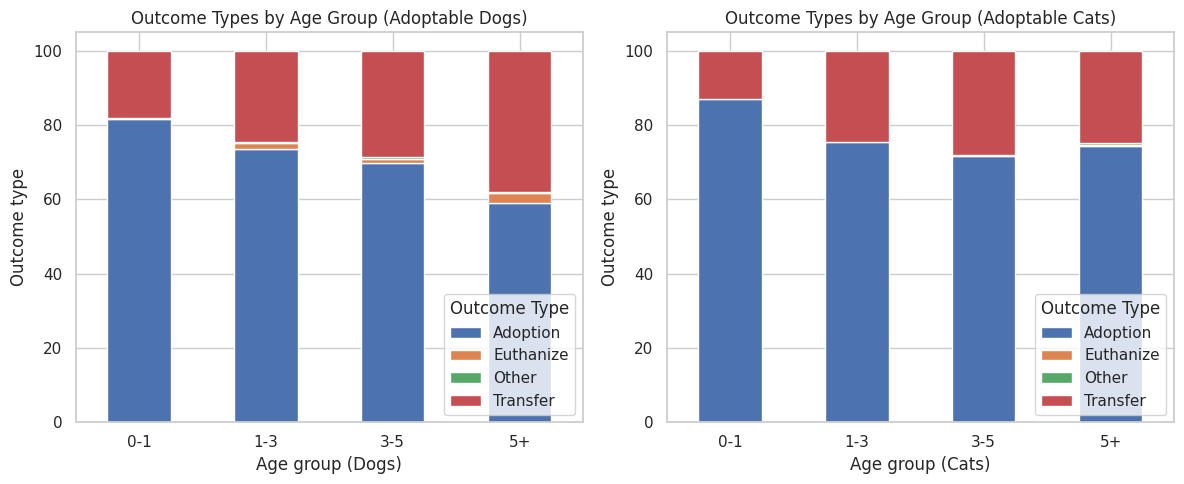

In [ ]:
dogCrosstab = pd.crosstab(df_adoptable_dogs['Age Group'], df_adoptable_dogs['Outcome Type'],normalize='index')*100
catCrosstab = pd.crosstab(df_adoptable_cats['Age Group'], df_adoptable_cats['Outcome Type'],normalize='index')*100
fig,ax = plt.subplots(1, 2, figsize=(12,5))
dogCrosstab.plot.bar(stacked=True,ax=ax[0],rot=0)
ax[0].set_title('Outcome Types by Age Group (Adoptable Dogs)')
ax[0].set_ylabel('Outcome type')
ax[0].set_xlabel('Age group (Dogs)')
ax[0].legend(loc='lower right', title='Outcome Type')
catCrosstab.plot.bar(stacked=True,ax=ax[1],rot=0)
ax[1].set_title('Outcome Types by Age Group (Adoptable Cats)')
ax[1].set_ylabel('Outcome type')
ax[1].set_xlabel('Age group (Cats)')
ax[1].legend(loc='lower right', title='Outcome Type')
fig.tight_layout()
plt.show();

**Interpret**:

Clearly, as animals get older, they are less likely to be adopted than puppies and kittens, but not by much if we factor out animals that already have owners, or unhealthy animals. Healthy older cats enjoy a nearly 75% adoption rate.

**Motivate**:

We've seen a few plots about the number of days spent in the shelter so far, but it's important to understand the actual distribution of the number of days  adopted animals spend in the shelter.

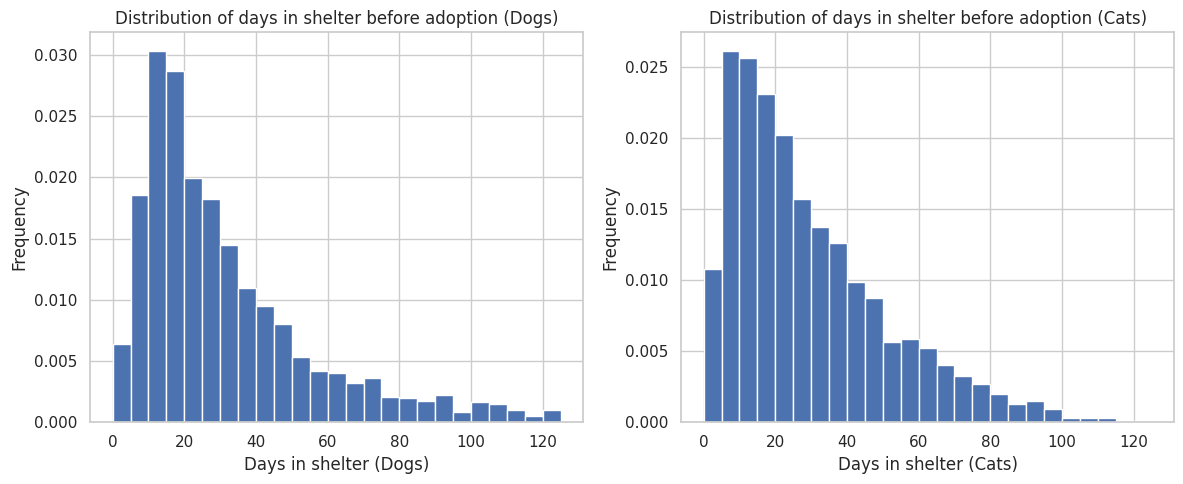

In [ ]:
df_filtered_dogs = df_dogs[df_dogs['Outcome Type']=='Adoption']
df_filtered_cats = df_cats[df_cats['Outcome Type']=='Adoption']

bins = [i * 5 for i in range(26)]
fig,ax = plt.subplots(1, 2, figsize=(12,5))
df_filtered_dogs['Days in Shelter'].plot.hist(bins=bins, ax=ax[0],density=True)
ax[0].set_title('Distribution of days in shelter before adoption (Dogs)')
ax[0].set_xlabel('Days in shelter (Dogs)')
df_filtered_cats['Days in Shelter'].plot.hist(bins=bins, ax=ax[1],density=True)
ax[1].set_title('Distribution of days in shelter before adoption (Cats)')
ax[1].set_xlabel('Days in shelter (Cats)')

fig.tight_layout();

**Interpret**:

Very few animals ever get adopted in the first 5 days after arriving at the shelter, likely as a matter of shelter policies. However, after that, most adoptions occur within the first 20 days for both dogs and cats. Unlike dogs, almost no cats take longer than 100 days to be adopted.

### Final Scatterplot Summary

**Motivate**:

Finally, we want to find out if there are any clear patterns based on the outcome date for dogs and cats. The following scatterplot shows the number of days an animal spent in the shelter against its outcome date. The color of each point indicates the animal's outcome type, and the shape of a point indicates the animal's age group.

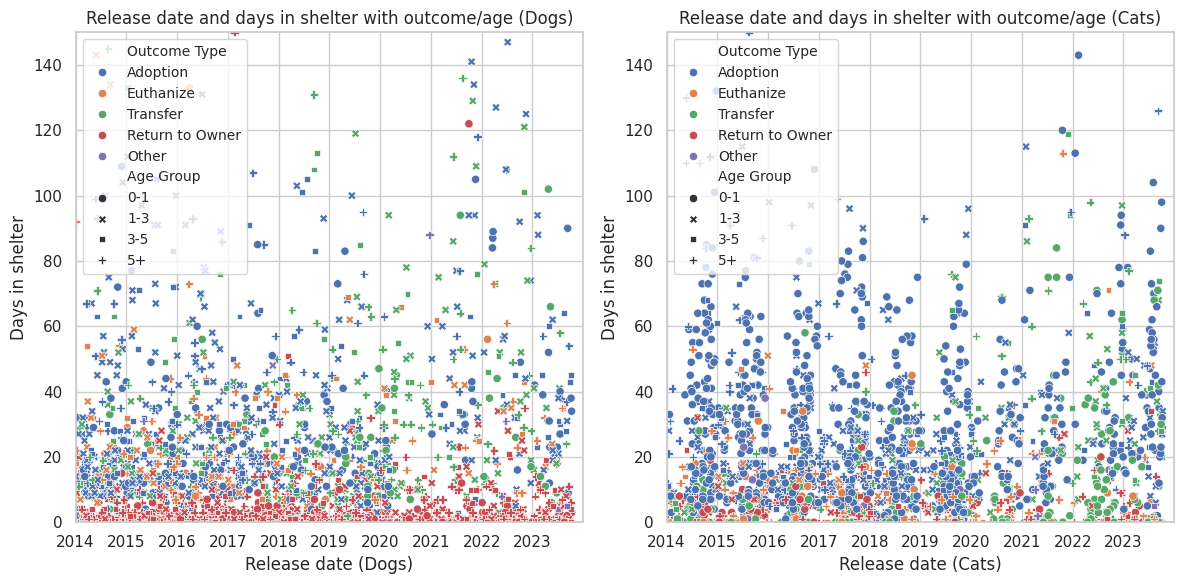

In [ ]:
# We want to keep the plots relatively easy to read, so we're limiting them to 3000 points each
df_filtered_dogs=df_dogs.sample(3000)
df_filtered_cats=df_cats.sample(3000)
fig,ax = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(x='Outcome Date', y='Days in Shelter', data=df_filtered_dogs, hue='Outcome Type',style='Age Group',ax=ax[0],hue_order=outcome_type_order)
ax[0].set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2023-12-31'))
ax[0].set_ylim(0,150)
ax[0].set_title('Release date and days in shelter with outcome/age (Dogs)')
ax[0].set_xlabel('Release date (Dogs)')
ax[0].set_ylabel('Days in shelter')
ax[0].legend(loc='upper left',fontsize='10')
sns.scatterplot(x='Outcome Date', y='Days in Shelter', data=df_filtered_cats, hue='Outcome Type',style='Age Group',ax=ax[1],hue_order=outcome_type_order)
ax[1].set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2023-12-31'))
ax[1].set_ylim(0,150)
ax[1].set_title('Release date and days in shelter with outcome/age (Cats)')
ax[1].set_xlabel('Release date (Cats)')
ax[1].set_ylabel('Days in shelter')
ax[1].legend(loc='upper left',fontsize='10')
fig.tight_layout();

**Interpret:**

A few patterns that we couldn't see before stand out in these plots. For dogs, the majority of red (return to owner) points lie at the bottom of the graph, indicating that these dogs spend a short amount of time in the shelter. We can also see once again that they tend to have more outlier values for days in the shelter than cats do. The majority of euthanasias (orange) seem to happen in the first 50 days.

For cats, a series of blue circles (kitten adoptions) peaks indicate that every year, there is a surge of cat adoptions towards the later half of the year. What could cause this surge in adoptions? It may be that cats tend to give birth in spring and summer, leading to a rise in kitten populations, as well as the holiday season influencing new adoptions. Cats of all outcomes seem to spend a lot less time in the shelter overall than their canine counterparts, and cats are rarely euthanized after being sheltered for longer than 25 days.

## Conclusions

In our analysis, we first set out to explore the validity of "Black Dog Syndrome''. While our investigation of the data revealed that black was one of the less popular colors for dogs and cats, the difference between adoption rates for black dogs and cats is not substantial. Black dogs and cats seem to have comparable adoption rates and shelter stay lengths to other colors. Dog breed seemed to be a much stronger indicator of outcomes than color, with pit bulls being euthanized the most often. Additionally, the reason for an animal's intake often has a profound impact on what outcomes are available to it, with animals that are confiscated often being returned to the owner, and surrendered animals tending to secure new homes through adoption.

Health status upon intake, as well as age emerged as some of the most crucial factors that determine an animal's outcome. The majority of cat adoptions are for young kittens, and most dogs being adopted are young adult dogs. We also observed that the shelters almost never euthanize healthy animals. Duration of shelter stay is also closely tied to adoption outcomes, with animals tending to be adopted in the first 20 days of intake. An interesting temporal trend also emerged for cats, revealing that cat adoptions tend to spike in the second half of the year.

To conclude, this analysis offers insight into the factors that shape the lives of animals that come into and out of the Sonoma County shelter system, revealing the relationships between color, breed, intake circumstances, and time with each animal's ultimate outcome.



